In [1]:
%autosave 10

Autosaving every 10 seconds


<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

<h1 align="center"> CIFAR-10 - Object Recognition in Images </h1>
![](http://pytorch.org/tutorials/_images/cifar10.png)

## Data Introduction
The CIFAR-10 data consists of **60,000** 32x32 color images in **10 classes**, with 6000 images per class. There are **50,000 training images** and **10,000 test images** in the official data.

CIFAR-10 has the classes: 
- airplane 
- automobile 
- bird
- cat 
- deer
- dog
- frog
- horse
- ship
- truck


## Import Packages


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import bokeh
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score, GridSearchCV
import pickle
import sklearn
from __future__ import print_function
%matplotlib inline

In [3]:
print('The scikit-learn version is {}.'.format(sklearn.__version__))
print('The PyTorch version is {}.'.format(torch.__version__))
print('The NumPy version is {}.'.format(np.__version__))
print('The Matplotlib version is {}.'.format(mpl.__version__))

The scikit-learn version is 0.18.1.
The PyTorch version is 0.1.12_2.
The NumPy version is 1.12.1.
The Matplotlib version is 1.5.1.


## Training an image classifier

We will do the following steps in order.

### Step1: Load and normalizing the CIFAR10 training and test datasets using ```torchvision```

The output of torchvision datasets are PILImage images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1]

The ```transforms.Compose(transforms)``` class Composes several transforms together.

<p  style="color:blue;"> Parameters:</p>
<ul  style="color:red;">
    <li>  transforms (List[Transform]): – list of transforms to compose.</li>
</ul>

In our case we are going to do two transforms:
- ```ToTensor()```
- ```Normalize()```


In [4]:
transform = transforms.Compose(
             [transforms.ToTensor(), 
              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [5]:
# Load the training and test datasets
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True,
                                        transform = transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=5,
                                         shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=5,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

### Data Exploration
Let's plot some training images

In [7]:
def plot_images(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='nearest')
    
    

    frog      car    plane     deer    truck


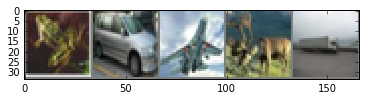

In [13]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# Plot images
plot_images(torchvision.utils.make_grid(images, nrow=5, padding=1))

# print labels
print(' '.join('%8s' % classes[labels[j]] for j in range(5)))

In [9]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>